# COMP 562 Final Project
#### By: Vidya Ramesh, Anita Murali, Soumya Mahavadi, Ximena Colopy
## Naive Bayes on Natural Disaster Tweets
This notebook uses a multinomial Naive Bayes classifier to label tweets as either talking about or **not** talking about a natural disaster.

In [1]:
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import string
import tensorflow as tf

In [2]:
# Load data files
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
# Preprocessing
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [4]:
# Separate features and target variable
X = df_train["text"]
Y = df_train["target"]

# Split training dataset into training and validation datasets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=VAL_SPLIT, random_state=42)
X_test = df_test["text"]

In [5]:
# Downloads list of common stopwords for various languages and Punkt tokenizer models
nltk.download('stopwords')
nltk.download('punkt')

def preprocess(text):
    # Break down text line into list of tokens
    words = word_tokenize(text)
    # Remove punctuation mark tokens
    words_no_punct = [word for word in words if word not in string.punctuation]
    # Load English stopwords
    stop_words = set(stopwords.words('english'))
    # Remove tokens that are stopwords
    words_no_stop = [word for word in words_no_punct if word.lower() not in stop_words]

    cleaned_text = ' '.join(words_no_stop)
    return cleaned_text

X_train_cleaned = [preprocess(line) for line in X_train]
X_val_cleaned = [preprocess(line) for line in X_val]
X_test_cleaned = [preprocess(line) for line in X_test]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


========== F1 Score ==========
0.7416267942583733
======= Accuracy Score =======
0.7872619829284307
====== Confusion Matrix ======


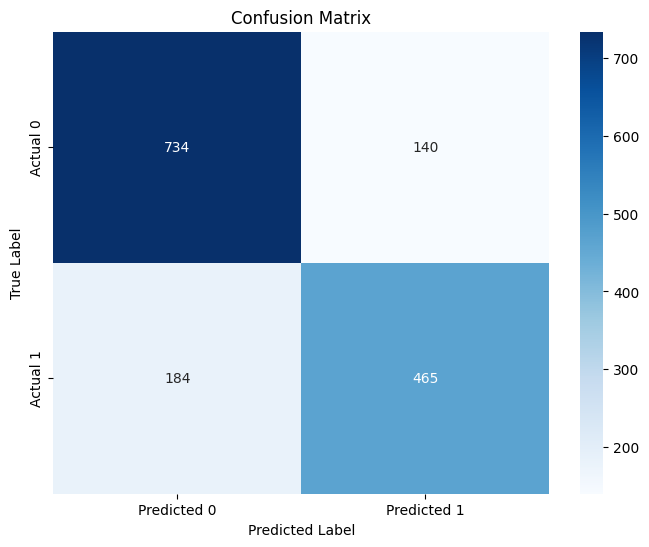

====== ROC Curve and AUC ======
0.7781519182830124


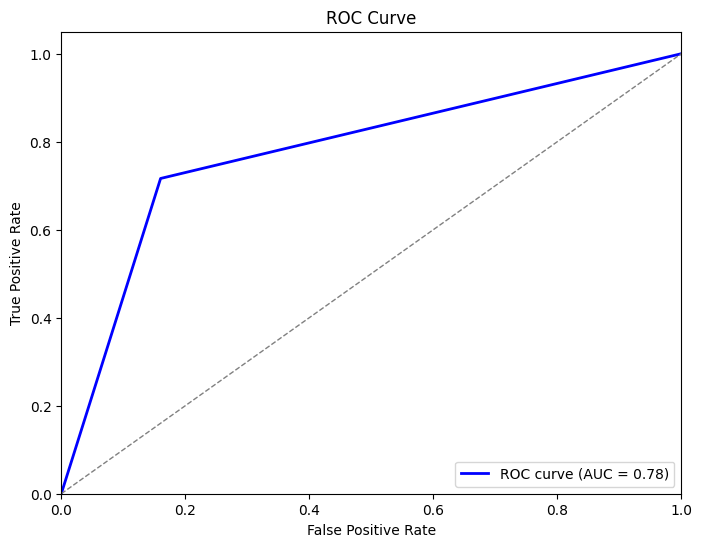

=======Average Precision Score===========
0.6715024632969923
==== Precision-Recall Curve ====


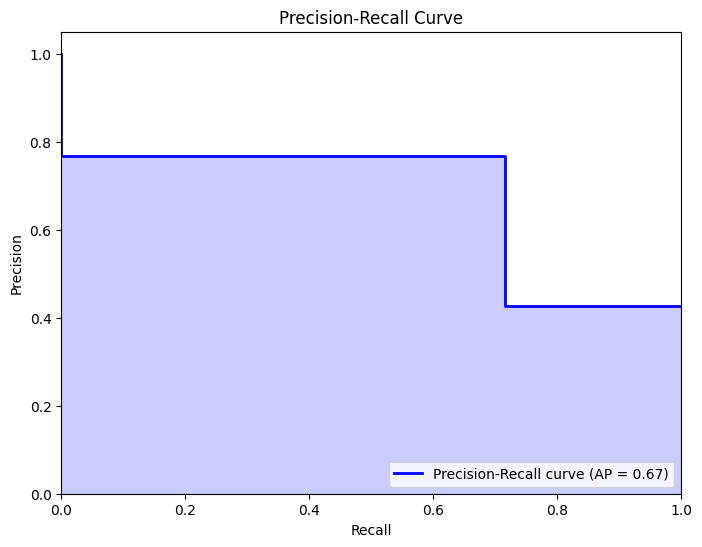

In [8]:
vectorizer = CountVectorizer()

# Fit and transform training data into a document-term matrix (DTM)
X_train_dtm = vectorizer.fit_transform(X_train_cleaned)
# Transform validation data into a DTM
X_val_dtm = vectorizer.transform(X_val_cleaned)
# Transform test data into a DTM
X_test_dtm = vectorizer.transform(X_test_cleaned)

# Initialize and train a Multinomial Naive Bayes Classifier
classifier = MultinomialNB()
classifier.fit(X_train_dtm, Y_train)

# Predict probabilities on the validation set
val_predictions = classifier.predict(X_val_dtm)

# Calculate F1 score on validation set
print("========== F1 Score ==========")
f1 = metrics.f1_score(Y_val, val_predictions)
print(f1)

# Calculate accuracy on validation set
print("======= Accuracy Score =======")
accuracy = metrics.accuracy_score(Y_val, val_predictions)
print(accuracy)

# Make predictions on the test set
test_predictions = classifier.predict(X_test_dtm)

# Generate and plot confusion matrix
print("====== Confusion Matrix ======")
confusion = confusion_matrix(Y_val, val_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Predict probabilities
Y_probs = classifier.predict(X_val_dtm)

# Compute ROC Curve and AUC
print("====== ROC Curve and AUC ======")
fpr, tpr, thresholds = roc_curve(Y_val, Y_probs)
auc_score = auc(fpr, tpr)
print(auc_score)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Calcuate Precision-Recall Curve
precision, recall, _ = precision_recall_curve(Y_val, Y_probs)
# Compute Average Precision Score
avg_precision = average_precision_score(Y_val, Y_probs)
print("=======Average Precision Score===========")
print(avg_precision)

print("==== Precision-Recall Curve ====")
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='blue', where='post', lw=2, label='Precision-Recall curve (AP = %0.2f)' % avg_precision)
plt.fill_between(recall, precision, alpha=0.2, color='blue', step='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()